## Movie recommender system considering non linear dependency amongst user and item feature matrices

### This one uses Approach 2 where we consider non linear equation and matrix facrorisaion is used to predict ratings and recommendations

MSE = (R - X $\theta$)^2

MSE  = Mean square error

R = Original Rating Matrix

X = Movie Matrix

Obective function ,

$$\min J(x,\theta) = \frac{1}{2}(X\theta - R)^2 + \frac{\lambda}{2} \theta^2 + \frac{\lambda}{2} x^2 $$

Gradient X,

$$\nabla_{\theta} = \frac{\partial J}{\partial x} = (X\theta - R)\theta + X $$

Gradient $ \theta,$

$$\nabla_{\theta} = \frac{\partial J}{\partial \theta} = (X\theta - R)X + \theta $$

Update X,

$$x_{k+1} = x_k - \alpha \nabla_{\theta} $$

Update $ \theta,$

$$\theta_{k+1} = \theta_k - \alpha \nabla_{\theta} $$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm

In [3]:
# Importing the data
movies = pd.read_csv(r"C:\Users\nithu\Documents\Project\Recommender\ml-latest-small\ml-latest-small\movies.csv")
ratings = pd.read_csv(r"C:\Users\nithu\Documents\Project\Recommender\ml-latest-small\ml-latest-small\ratings.csv")

In [4]:
len(ratings)

100836

In [5]:
# Splittin the data and hiding the data by inserting nan values and reinserting it into original data
# This data will then be used later to check accuracy against predicted ratings
from sklearn.model_selection import train_test_split
X_ratings,Y_ratings = train_test_split(ratings,test_size=0.1, random_state=42)

new = Y_ratings.copy()
new['rating'] = np.nan

train_ratings = pd.concat([X_ratings, new], ignore_index=True, axis=0)

train_ratings=ratings.drop(['timestamp'], axis=1)
# Pivoting the table
MovieUserMatrix = train_ratings.pivot_table(index='movieId',columns='userId',values='rating')
MovieUserMatrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Creating a binary matrix and intiating initial matrix with nan value with -1 rating
MovieUserMatrix_Y=MovieUserMatrix.fillna(-1)
MovieUserMatrix_R=MovieUserMatrix.copy()
MovieUserMatrix_R=MovieUserMatrix_R.where(~MovieUserMatrix_R.notna(), 1)
MovieUserMatrix_R=MovieUserMatrix_R.fillna(0)

In [7]:
Y=MovieUserMatrix_Y.values
R=MovieUserMatrix_R.values

In [8]:
def  CostFunc(p,q, Y, R, num_users, num_movies, num_features, Lambda):

    X = p
    Theta = q
    
    predictions =  np.dot(X,Theta.T)
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)# multiplying by R will consider only those values for which value of (i,j)=r(i,j)=1
    
    #compute regularized cost function
    reg_X =  Lambda/2 * np.sum(X**2)
    reg_Theta = Lambda/2 *np.sum(Theta**2)
    reg_J = J + reg_X + reg_Theta
    
    # Compute gradient
    X_grad = np.dot(err*R,Theta)
    Theta_grad = np.dot((err*R).T,X)
    
    # Compute regularized gradient
    reg_X_grad = X_grad + Lambda*X
    reg_Theta_grad = Theta_grad + Lambda*Theta
    
    return reg_J, reg_X_grad, reg_Theta_grad

In [9]:
def gradientDescent(p,q,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
 
    J_history =[]
    # calling cost function over each iteration and then using the gradient value to update/obtain next value for 
    # p and q and obtain the minimum value for the cost function
    for i in range(num_iters):
        cost, reg_X_grad, reg_Theta_grad = CostFunc(p,q, Y, R, num_users, num_movies, num_features, Lambda)
        
        p = p - (alpha * reg_X_grad)
        q = q - (alpha * reg_Theta_grad)
        J_history.append(cost)

    return p, q ,J_history

### HyperParameter Tuning

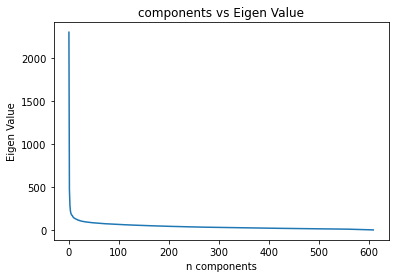

In [10]:
# Taking SVD of the rating matrix and checking the scree plot of it
U,S,VT = np.linalg.svd(Y)
plt.xlabel("n components")
plt.ylabel('Eigen Value')
plt.title("components vs Eigen Value")
plt.plot(S)

In [11]:
# Taking first 10 components of the SVD as it would be sufficient as per the graph for approximate 
# reconstriction of the whole matrix
u = U[:,:10]
s = S[:10]
v = VT[:10,:]

In [12]:
# Taking percentage of the Singular values
s1 = s/np.sum(s)
s1

array([0.53279474, 0.11042775, 0.06752331, 0.05206761, 0.04503522,
       0.04233867, 0.0400133 , 0.03901933, 0.03589998, 0.03488009])

In [13]:
from sklearn.preprocessing import MinMaxScaler
# Different lambda values to check the accuracy of the model for later usage
Lambda = [0.6,0.9,1.2,1.4]
cost = []
rmse = []
r2 = []

num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Calculating the MSE(Mean Square Error) and R2 score for different values of lambda
for i in tqdm(Lambda):
    p = u
    q = np.dot(np.diag(s1),v).T

    
    X, Theta, J_history = gradientDescent(p,q,Y,R,num_users,num_movies,num_features,0.001,1000,i)
    cost.append(J_history)
    
    final = np.dot(X,Theta.T)
    
    #scaling the values obtained from 1 to 5
    scaler1 = MinMaxScaler(feature_range=(1, 5))
    final_norm = scaler1.fit_transform(final)
    
    FinalratingM = pd.DataFrame(final_norm, index=MovieUserMatrix.index, columns=MovieUserMatrix.columns)
    
    userId = Y_ratings['userId']
    movieId = Y_ratings['movieId']
    y_true = Y_ratings['rating']
    y_pred = []
    for i,j in zip(movieId,userId):
        y_pred.append(FinalratingM.loc[i,j])
    rmse.append(mean_squared_error(y_true,y_pred))

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [10:06<00:00, 151.69s/it]


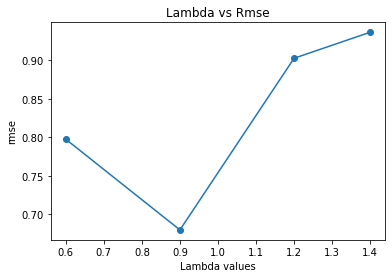

In [15]:
plt.plot(Lambda,rmse,marker = 'o')
plt.xlabel("Lambda values")
plt.ylabel("rmse")
plt.title("Lambda vs Rmse")
plt.show()

## Final Training

In [16]:
U,S,VT = np.linalg.svd(Y)
u = U[:,:10]
s = S[:10]
v = VT[:10,:]

s1 = s/np.sum(s)
s1

p = u
q = np.dot(np.diag(s1),v).T

In [17]:
p.shape

(9724, 10)

In [18]:
q.shape

(610, 10)

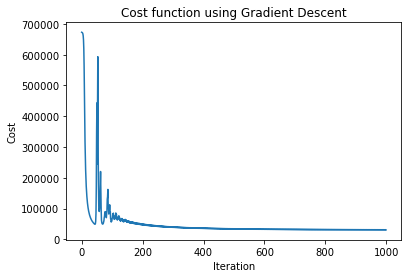

In [19]:
# Lambda is taken as 0.9 as that gives us the best result
Lambda = 0.9

num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
# alpha as 0.001 and iteration as 1000
X,Theta, J_history = gradientDescent(p,q,Y,R,num_users,num_movies,num_features,0.001,1000,Lambda)

plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost function using Gradient Descent")
plt.show()

In [20]:
final = np.dot(X,Theta.T)

scaler1 = MinMaxScaler(feature_range=(1, 5))
final_norm = scaler1.fit_transform(final)
#Final ratings converted into datafrane
FinalratingM = pd.DataFrame(final_norm, index=MovieUserMatrix.index, columns=MovieUserMatrix.columns)
    
userId = Y_ratings['userId']
movieId = Y_ratings['movieId']
y_true = Y_ratings['rating']
y_pred = []
#Adding the predicted values separately
for i,j in zip(movieId,userId):
    y_pred.append(FinalratingM.loc[i,j])

In [23]:
# Checking the accuracy
from sklearn.metrics import mean_squared_error
print('RMSE Score: ',mean_squared_error(y_true,y_pred))

RMSE Score:  0.679767360747662


## Predicting top 10 movies for a user

In [22]:
# Specifying the id of the user and no of movies to recommend
user = 105
no_of_movies = 10

#Obtain the ratings and binary values of the inital matrix using user ID
ratings = FinalratingM.loc[:,user]
binary = MovieUserMatrix_R.loc[:,user]

movieid = pd.Series(MovieUserMatrix.index)   #To store the all the movie ID

df = pd.concat([ratings,binary], axis=1)
df.reset_index(inplace = True)
df.columns = ['movieId','ratings', 'binary']

# Sorting the dataframe in decending order i.e. highest rated movies first
final_df = df.sort_values(by=['ratings'], ascending=False)

n = 0
List = []
# Looping through the whole dataframe and checking binary data and only those 
# which was never rated by the user is recommended to the user
for i in range(len(final_df)):
    if (final_df['binary'].iloc[i] == 0):
        List.append(final_df['movieId'].iloc[i])
        n = n+1
    if n == no_of_movies:
        #stop/ exit the loop when the count reaches number of movies needed to be recommended is reached
        break

# Sorting the list of movies as obtained above for recommendation
a=movies.loc[movies['movieId'].isin(List)]['title']
print("Top 10 Movies that are recommended to User", user,":")
print(a)

Top 10 Movies that are recommended to User 105 :
1596          Watership Down (1978)
1703       Stardust Memories (1980)
4140          Antwone Fisher (2002)
4150                 My Girl (1991)
5072       Bridge Too Far, A (1977)
5664    Battlestar Galactica (2003)
6038        Weather Man, The (2005)
6401         Hannibal Rising (2007)
6487                    Once (2006)
7091           Julie & Julia (2009)
Name: title, dtype: object
